# Predict Patient No Shows

**Purpose**<br>
In this presentation, we will examine a public dataset containing a subset of patient demographics, conditions, and attendance for their scheduled appointments. We will explore the the dataset, build a model, and evaluate its accuracy on a test set. This will launch us into a discussion on the strengths and limitations of the dataset, methods for model building, and the best practices for deploying a model to predict patient no-shows in the clinical environment. AI development is frequently compared to the wild west. In this presentation we seek to reinforce the critical need for clinical experts to collaborate with the development community to ensure algorithm development is moving in a direction that ultimately improves the quality and practice of radiological care. 


**Learning Objectives** <br>
- Walk meeting participants through a machine learning model. Understand how we evaluate these models.
- See the limitations in the dataset. How might clinican expertise improve this model?
- Provide an OSS base for participants to study and improve upon model performance at their facilities. 
- Understand the impetus behind use cases and why we need domain experts to guide the community through practical and ethical considerations.

**General Plan**

1. Lay out the Scenario
2. Pitch the algorithm
3. Walkthrough data analysis and model building
3. Try to break into the black box: Discovering algorithm strength and weaknesses
4. Discuss best practices for integrating a No-Show model in clincial environments

**Credit**<br>
Laura Brink, Deepak Kattilveettil, Mona Elkholy, Joni Hoppen

## Scenario

You are on the tech advisory committee for your facility that's tasked with finding worthwhile applications that could improve the quality and practice of our local facility(Insert a daily volume estimate of a small facility size). Vendor XYZ has approached your working group and shared one of their data sources & notebooks for building their algorithm. You are examining their work to evaluate whether to their solutions could help your facility...



## Algorithm Highlights

- Trainied and tested on over 110k patient appointments
- Recorded 92% accuracy on the test dataset
- Recorded 95% precision on the test dataset
- Mean square error on the test dataset of 0.0494
- Given 14 features on patient appointments in original data. Built the model with 25 after feature engineering. Accuracy likely to improve with even more features upfront.
- Identified correlations among the variables that could be sources for future research to predict patient no-shows or even more generally manage the health of local populations

## Walkthrough data analysis and model building

### Setup the environment

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn import ensemble
#from sklearn import datasets
import seaborn as sns;
#may not need datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [2]:
#import csv data
df = pd.read_csv("KaggleV2-May-2016.csv")

This [public dataset](https://www.kaggle.com/joniarroba/noshowappointments) is hosted on Kaggle under [Creative Commons BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/)


>[Kaggle](https://www.kaggle.com) is an online community of data scientists and machine learners, owned by Google LLC. Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

[Kaggle Wikipedia Entry](https://en.wikipedia.org/wiki/Kaggle)

### Data Cleansing

In [3]:
# set an index object for manipulating tables later
index = df.index
# quick sample of the data
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [5]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


We can make a few changes to make this data more readable to humans and machine.

- Let's eliminate the negation and title the column 'Attendance'. So the field, No-Show {No / Yes}, would translate to Attendance {1 / 0}

- Also, let's cleanup the spelling on the column headers. For example hypertension and handicap are misspelled.

- Convert Gender {M / F} to Gender {1 / 0} for easier application in our models


In [6]:
#The only field with Yes/No is the No-Show column. Let's change this from 'no show' to 'attendance'. Thus patients 
#marked with Yes for no-show would be a 0 for attendance. 
df = df.replace('No', 1)
df = df.replace('Yes',0)

#Change Male to 1 and female to 0
df = df.replace('M',1)
df = df.replace('F', 0)

df = df.rename(columns={"PatientId": "PatientId", "AppointmentID": "AppointmentID", "Gender":"Gender", 
                   "ScheduledDay":"ScheduledDay","AppointmentDay":"AppointmentDay", "Age":"Age",
                   "Neighbourhood":"Neighborhood", "Scholarship":"Scholarship", "Hipertension":"Hypertension", 
                   "Diabetes":"Diabetes","Alcoholism":"Alcoholism","Handcap":"Handicap", "SMS_received":"SMS_Reminders",
                  "No-show":"Attendance"})

In [7]:
print("There are", df.shape[0], "records and", df.shape[1], "features \n")
print(df.describe())

There are 110527 records and 14 features 

          PatientId  AppointmentID         Gender            Age  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06       0.350023      37.088874   
std    2.560949e+14   7.129575e+04       0.476979      23.110205   
min    3.921784e+04   5.030230e+06       0.000000      -1.000000   
25%    4.172614e+12   5.640286e+06       0.000000      18.000000   
50%    3.173184e+13   5.680573e+06       0.000000      37.000000   
75%    9.439172e+13   5.725524e+06       1.000000      55.000000   
max    9.999816e+14   5.790484e+06       1.000000     115.000000   

         Scholarship   Hypertension       Diabetes     Alcoholism  \
count  110527.000000  110527.000000  110527.000000  110527.000000   
mean        0.098266       0.197246       0.071865       0.030400   
std         0.297675       0.397921       0.258265       0.171686   
min         0.000000       0.000000       0.000000       0.000000   

On first glance, we see that about 80% of patients attend their appointment. Is there anything about the 20% who do not make their appointment that would allow us to predict a no-show?

### Identify outliers to narrow the scope of the algorithm and improve accuracy

Most fields are binaries which make it a bit more difficult to sift out outliers in our dataset. Age immediately grabs attention as there are some patients labelled -1 and 115. Let's take a closer look. 

Text(0.5, 1.0, 'Ages represented in the data')

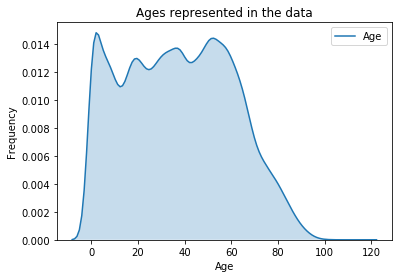

In [8]:
sns.kdeplot(df.Age, shade = True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Ages represented in the data')

Remove ages -1 as well as those >= 100 from the data

In [9]:
df = df[(df.Age >=0) & (df.Age < 100)]

Text(0.5, 1.0, 'Attendance by Age')

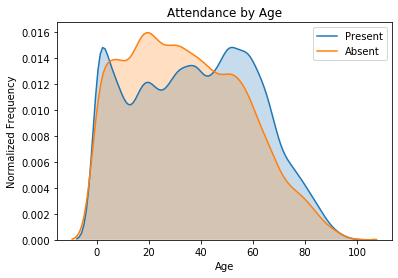

In [10]:
# Attendance distribution by Age
sns.kdeplot(df.loc[df['Attendance'] == 1, 'Age'], label = 'Present', shade = True)
sns.kdeplot(df.loc[df['Attendance'] == 0, 'Age'], label = 'Absent', shade = True)
plt.xlabel('Age')
plt.ylabel('Normalized Frequency')
plt.title('Attendance by Age')

- Young people are more likely to miss their appointment that attend, particularly between the ages of 15-50.
- Older patients are more likely to attend their appointments.

### Date Analysis

Let's take a look at what dates we're examining here. We have both scheduled date and appointment date to dig into. Unfortunately the appointment date only provides the day/month/year of the visit while scheduled date gives the time of day. Some features we can extract from this data:

- WaitingDays : difference between scheduled date and appointment date
- AppointmentDayofWeek : Mon / Tues / Wed / Thurs / Fri / Sat / Sun
- ScheduledDayofWeek : Mon / Tues / Wed / Thurs / Fri / Sat / Sun
- AppointmentTimeOfDay: AM / PM



In [11]:
print(df.AppointmentDay.head(),
df.ScheduledDay.head())

0    2016-04-29T00:00:00Z
1    2016-04-29T00:00:00Z
2    2016-04-29T00:00:00Z
3    2016-04-29T00:00:00Z
4    2016-04-29T00:00:00Z
Name: AppointmentDay, dtype: object 0    2016-04-29T18:38:08Z
1    2016-04-29T16:08:27Z
2    2016-04-29T16:19:04Z
3    2016-04-29T17:29:31Z
4    2016-04-29T16:07:23Z
Name: ScheduledDay, dtype: object


In [12]:
#Pandas offers nifty support for analyzing datetimes. Let's convert these series into pandas 
#datatime objects with pd.to_datetime
df.ScheduledDay = pd.to_datetime(df.ScheduledDay)
df.AppointmentDay = pd.to_datetime(df.AppointmentDay)
print("Appointments occur between",df.AppointmentDay.min(),"and", df.AppointmentDay.max())

Appointments occur between 2016-04-29 00:00:00+00:00 and 2016-06-08 00:00:00+00:00


- This is **roughly five weeks** of appointments. This is likely another major limitation of building a model from this data.
- Notice that hour:min:sec data is not recorded for the appointment though this data is captured for the scheduling time

Text(0.5, 1.0, 'Mean Attendance by appointment day of week')

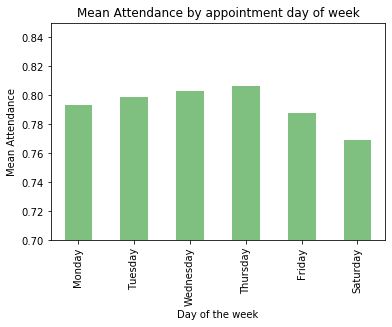

In [13]:
##Create a new column that tracks the appointment day of week (Mon, Tuesday, Wednesday, Thurs, Fri, Sat, Sun)
## Add this new column to our dataframe
df['AppointmentDayOfWeek'] = df.AppointmentDay.map(lambda day: day.day_name())

SMSbyAppointment = df['Attendance'].groupby(df['AppointmentDayOfWeek'],sort=False)

SMSbyAppointment.mean().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']).plot.bar(color='green', alpha=0.5)
plt.ylabel('Mean Attendance')
plt.xlabel('Day of the week')
plt.ylim((0.7, 0.85))
plt.title('Mean Attendance by appointment day of week')

- Drop in attendance on Friday and Saturday
- Highest attendance on Wednesday and Thursday appointments 

In [14]:
#creates dummy variables to account for AppointmentdAyOfWeek Categorical data
dummy = pd.get_dummies(df.AppointmentDayOfWeek)
df= pd.concat([df,dummy], axis =1)

Text(0.5, 1.0, 'Rate of SMS Reminders Sent By Schedule Date')

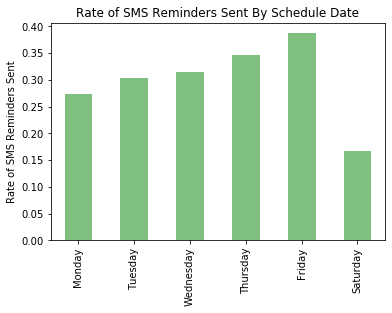

In [15]:
##Create a new column that tracks the scheduled day of week
df['ScheduledDayOfWeek'] = df.ScheduledDay.map(lambda day: day.day_name())

SMSbySchedule = df['SMS_Reminders'].groupby(df['ScheduledDayOfWeek'])

SMSbySchedule.mean().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']).plot.bar(color='green',alpha=0.5)
plt.ylabel('Rate of SMS Reminders Sent')
plt.xlabel('')
plt.title('Rate of SMS Reminders Sent By Schedule Date')

- Sharp drop in text rates for appointments scheduled on saturday.
- Other than saturday, as the week progresses, so does the rate of texts sent from the facility

More SMS were sent later in the week, though the facilities sent out fewer texts when the appointment was scheduled on a Saturday. How many instances are there of a patient scheduleding their appointment on a saturday?

In [16]:
df.ScheduledDayOfWeek.apply(lambda x: str(x))
print("There are",df[df.ScheduledDayOfWeek=='Saturday'].shape[0],"instances of an appointment scheduled on Saturday")

There are 24 instances of an appointment scheduled on Saturday


Let's drop these as they don't seem to be representative of the relationship for SMS_reminders on attendance.

In [17]:
df = df[df.ScheduledDayOfWeek!='Saturday']

In [18]:
def convertdaytonumber(day):
    if day == 'Monday':
        return 1
    if day == 'Tuesday':
        return 2
    if day == 'Wednesday':
        return 3
    if day == 'Thursday':
        return 4
    if day == 'Friday':
        return 5
    if day == 'Saturday':
        return 6
    if day == 'Sunday':
        return 7

##Create a new column that tracks the scheduled day of week
df['ScheduledDayOfWeekNumeric'] = df.ScheduledDayOfWeek.map(lambda day: convertdaytonumber(day))

In [19]:
##This will calculate the days in between appointment and scheduling date. Since the appointment column doens't have a
## time of appointment, we're rounding here. Basically removing the time format from the ScheduledDate section.
WaitFromScheduledDate = (df.AppointmentDay.map(lambda x: x.date()) - df.ScheduledDay.map(lambda x: x.date()))

df['WaitFromScheduledDate'] = WaitFromScheduledDate.map(lambda x: x.days)

Text(0, 0.5, 'Instances')

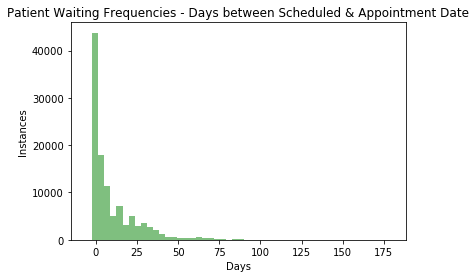

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.hist(df.WaitFromScheduledDate, bins = 50, color ='green', alpha = 0.5)
ax1.set_title('Patient Waiting Frequencies - Days between Scheduled & Appointment Date')
ax1.set_xlabel('Days')
ax1.set_ylabel('Instances')



In [21]:
df[df.WaitFromScheduledDate < 0].shape
df = df[df.WaitFromScheduledDate >= 0]
#Eliminate all records where wait time is less than 0 days

Negative difference between scheduled date and appointment day makes no sense. Drop these values.

In [22]:
print("Now there are", df.shape[0], "records in the dataframe")

Now there are 110486 records in the dataframe


Text(0.5, 1.0, 'Attendance by Waiting')

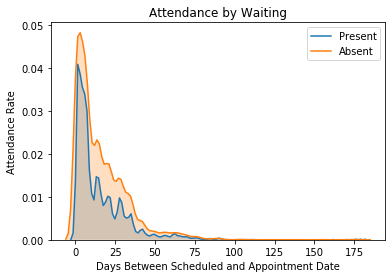

In [23]:
# Attemdance by waiting day
sns.kdeplot(df.loc[df['Attendance'] == 1, 'WaitFromScheduledDate'], label = 'Present', shade = True)
sns.kdeplot(df.loc[df['Attendance'] == 0, 'WaitFromScheduledDate'], label = 'Absent', shade = True)
plt.xlabel('Days Between Scheduled and Appointment Date')
plt.ylabel('Attendance Rate')
plt.title('Attendance by Waiting')


[-1, 30, 0, 0.1]

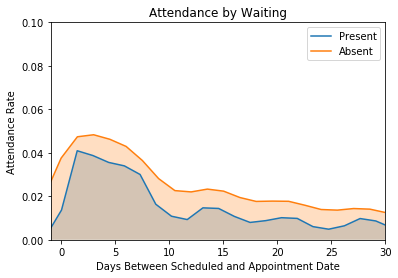

In [24]:
# Attendance distribution by waiting
sns.kdeplot(df.loc[df['Attendance'] == 1, 'WaitFromScheduledDate'], label = 'Present', shade = True)
sns.kdeplot(df.loc[df['Attendance'] == 0, 'WaitFromScheduledDate'], label = 'Absent', shade = True)
plt.xlabel('Days Between Scheduled and Appointment Date')
plt.ylabel('Attendance Rate')
plt.title('Attendance by Waiting')

plt.axis([-1,30,0,0.1])

I want to get a better idea of how SMS reminders were utilized, especially with respect to the scheduled and appointment dates. Some patients received reminders, others did not. Why is that?

were texts sent on aparticular day? Was this an automated system? 

Did SMS Reminders impact the attendance rate?

SMS_Reminders
0    0.833009
1    0.724208
Name: Attendance, dtype: float64

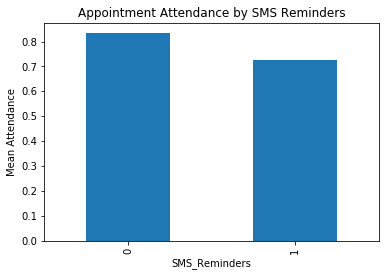

In [25]:
grouping = df['Attendance'].groupby(df['SMS_Reminders'])
grouping.mean().plot.bar()

plt.ylabel('Mean Attendance')
plt.title('Appointment Attendance by SMS Reminders')
grouping.mean()

Whoa. Those patients who did not receive an SMS reminders atteded their appointment 80% of the time compared to about 70% attendance among patients who received an SMS. This is a bit counter-intuitive. What's happening here? 


Perhaps the facility identifies patients at high risk of missing their appointment and sends SMS to those individuals? Perhaps its wealthier populations who can sign up for automated texting, who are also less likely to show up to a state-funded clinic appointment? Let's continue to dig into SMS relationships.

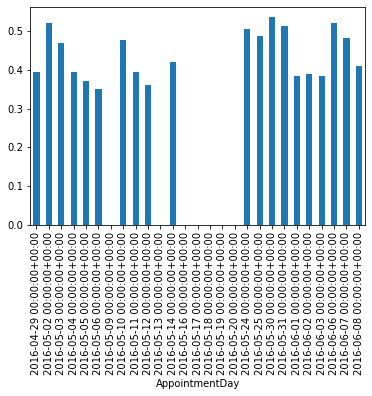

In [26]:
#How frequently are text messages sent from the facility?
grouping = df['SMS_Reminders'].groupby(df['AppointmentDay'])
grouping.mean().plot.bar()

There's over a week of time where appointments were taken, but no SMS reminders were sent! Was the system down? How many records is this?

In [27]:
#Confirming the dates when no texts were distributed
print(df[(df.AppointmentDay>="2016-05-15") & (df.AppointmentDay <= "2016-05-23")].SMS_Reminders.mean())

print("There are", df[(df.AppointmentDay>="2016-05-15") & (df.AppointmentDay <= "2016-05-23")].shape[0], "records during this window",
     "or", "{:.1%}".format(df[(df.AppointmentDay>="2016-05-15") & (df.AppointmentDay <= "2016-05-23")].shape[0]/df.shape[0]), "percent of the data")

0.0
There are 21446 records during this window or 19.4% percent of the data


It's costly to discard 19% of your data for model building/testing- but we should do so. For whatever reason texts were not distributed for a whole week on an already limited dataset. So it's going to be very tricky to make any determinations about how texting affects the attendance rate without accounting for this week.

Ran the models with and without these data. When removing this week worth of data, the accuracy improved by 2%. Models seems to have a much harder time to predict guage the attendance relationship when trying to account for this week. Let's remove this week of data.

In [28]:
df = df[(df.AppointmentDay<"2016-05-15") | (df.AppointmentDay > "2016-05-23")]

SMS_Reminders
0    0.853148
1    0.724208
Name: Attendance, dtype: float64

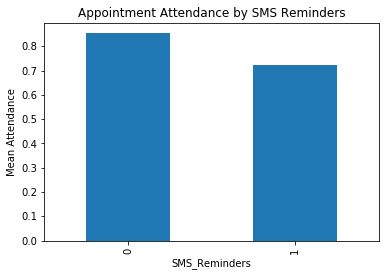

In [29]:
#Check the attendance to SMS relationship now.
grouping = df['Attendance'].groupby(df['SMS_Reminders'])
grouping.mean().plot.bar()

plt.ylabel('Mean Attendance')
plt.title('Appointment Attendance by SMS Reminders')
grouping.mean()

It's not even more glaring! People who did not receive an SMS were more likely to show up to their appointment. Waht else could be going on?

WaitFromScheduledDate
0    0.953069
1    0.790396
2    0.756226
3    0.763569
4    0.771698
5    0.742049
6    0.758652
7    0.729199
8    0.716075
9    0.728827
Name: Attendance, dtype: float64


Text(0.5, 1.0, 'Appointment Attendance by Days Awaiting Appointment')

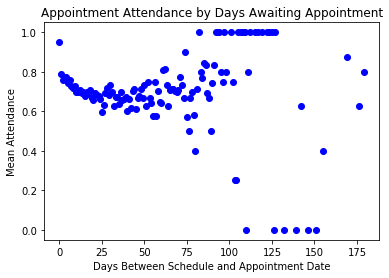

In [30]:
grouping = df['Attendance'].groupby(df['WaitFromScheduledDate'])
print(grouping.mean().head(10))
plt.plot(grouping.mean(), 'bo')
plt.ylabel('Mean Attendance')
plt.xlabel('Days Between Schedule and Appointment Date')
plt.title('Appointment Attendance by Days Awaiting Appointment')

People who made appointments THAT day were very likely to show up (~95%). Maybe these were patients who didn't receive an SMS? Let's check that grouping.

WaitFromScheduledDate
0    0.000000
1    0.000000
2    0.000000
3    0.416283
4    0.720283
5    0.806439
6    0.800716
7    0.736434
8    0.751566
9    0.774670
Name: SMS_Reminders, dtype: float64


Text(0.5, 1.0, 'SMS Reminder Rate by Days Awaiting Appointment')

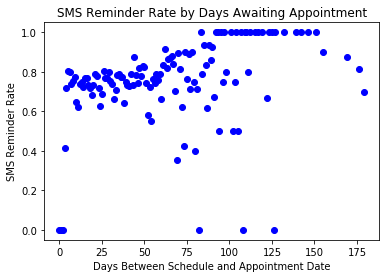

In [31]:
grouping = df['SMS_Reminders'].groupby(df['WaitFromScheduledDate'])
print(grouping.mean().head(10))
plt.plot(grouping.mean(), 'bo')
plt.ylabel('SMS Reminder Rate')
plt.xlabel('Days Between Schedule and Appointment Date')
plt.title('SMS Reminder Rate by Days Awaiting Appointment')

So patients who waited less than three days, did not receive SMS reminders for their appointment. 

In [32]:
print("Roughly", "{:.1%}".format(df[df.WaitFromScheduledDate == 0].shape[0]/df.shape[0]), "percent of the records are of patients who scheduled their appointment on that very day") 

Roughly 35.1% percent of the records are of patients who scheduled their appointment on that very day


Of those patients, 95% attended their appointment - so this is significantly skewing our data. Over one third of the data accounts for patients who scheduled that day and so received no text message. Let's remove this data.


In [33]:
df= df[df.WaitFromScheduledDate != 0]

In [34]:
##Can turn the datetime object into a new feature representing the hour of the day (24:00 clock)
def calculateHour(timestamp):
    timestamp = str(timestamp)
    hour = int(timestamp[11:13])
    minute = int(timestamp[14:16])
    second = int(timestamp[17:19])
    return round(hour + minute/60 + second/3600)

df['ScheduledHourOfDay'] = df.ScheduledDay.apply(calculateHour)

This will return the hour of the day closest to when the apointment was scheduled. Perhaps there's a time of day when setting follow-up reminders in place are missed. 

We're not applying this to AppointmentDay because that level of specificity wasn't tracked across the appointments in the original data (only year - month - day)

ScheduledHourOfDay
6     0.235294
7     0.787778
8     0.737370
9     0.719445
10    0.710617
11    0.695984
12    0.704487
13    0.696073
14    0.710841
15    0.703364
Name: Attendance, dtype: float64


Text(0.5, 1.0, 'Appointment Attendance by Scheduled Time of Day')

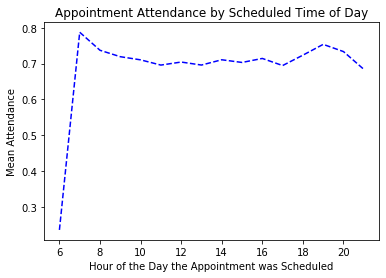

In [35]:
grouping = df['Attendance'].groupby(df['ScheduledHourOfDay'])
print(grouping.mean().head(10))
plt.plot(grouping.mean(), 'b--')
plt.ylabel('Mean Attendance')
plt.xlabel('Hour of the Day the Appointment was Scheduled')
plt.title('Appointment Attendance by Scheduled Time of Day')

Appointments scheduled earlier (at least after 6am) see a higher appointment attendance rate. 

Text(0.5, 1.0, 'Appointment Attendance by Scheduled Time of Day')

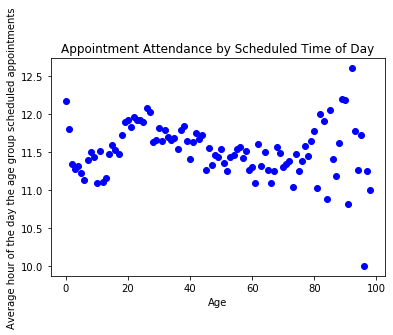

In [36]:
grouping = df['ScheduledHourOfDay'].groupby(df['Age'])
plt.plot(grouping.mean(), 'bo')
plt.ylabel('Average hour of the day the age group scheduled appointments')
plt.xlabel('Age')
plt.title('Appointment Attendance by Scheduled Time of Day')

Text(0.5, 1.0, 'Time of Day Scheduling the Appointment on Days Before Appointment')

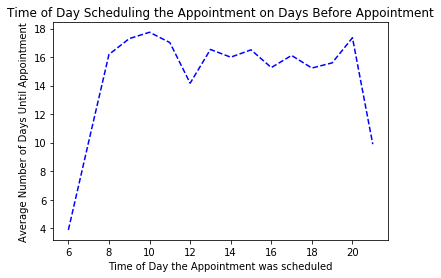

In [37]:
grouping = df['WaitFromScheduledDate'].groupby(df['ScheduledHourOfDay'])
plt.plot(grouping.mean(), 'b--')
plt.ylabel('Average Number of Days Until Appointment')
plt.xlabel('Time of Day the Appointment was scheduled')
plt.title('Time of Day Scheduling the Appointment on Days Before Appointment')


Few insights from this new variable

- Patients are less likely to attend appointments when scheduled later in the day
- Older patients tend to handle the scheduling process earlier in the day
- Appointments scheduled later in the day are typically closer to the actual date

**Link patients by patient ID**

In [38]:
print("There are",len(df.PatientId.unique()),"unique patients in the data")
print("There are",len(df.AppointmentID.unique()),"unique appointment Ids in the data")
print("{:.1%}".format(df.PatientId.unique().shape[0]/df.shape[0]), "of the data are unique patients")
print("{:.1%}".format(1-(df.PatientId.unique().shape[0]/df.shape[0]))," of the data are returning patients")



There are 39092 unique patients in the data
There are 57760 unique appointment Ids in the data
67.7% of the data are unique patients
32.3%  of the data are returning patients


There are 39092 unique patient Ids here... 
Number of previous missed appointments will probably be a good predictor for future absences. Let's create that column.

In [39]:
import matplotlib.pyplot as plt
ScheduledAppointmentFrequencies = pd.value_counts(df.PatientId.values, sort=True)


print("The mean number of scheduled appointments is ", ScheduledAppointmentFrequencies.mean())
ScheduledAppointmentFrequencies.describe()


The mean number of scheduled appointments is  1.4775401616699069


count    39092.00000
mean         1.47754
std          1.03626
min          1.00000
25%          1.00000
50%          1.00000
75%          2.00000
max         25.00000
dtype: float64

Text(0, 0.5, 'Count of patients')

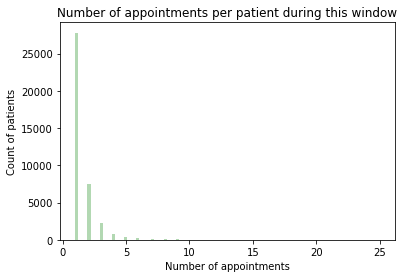

In [40]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.hist(ScheduledAppointmentFrequencies, bins = 100, color ='green', alpha = 0.3)
ax1.set_title('Number of appointments per patient during this window')
ax1.set_xlabel('Number of appointments')
ax1.set_ylabel('Count of patients')

We can see from this data that not many patients have scheduled more than five appointments for this month long period. We should be able to say that patients scheduling ten or more times are outliers and should be treated differently by this model. These patients are basically seen once every two-three days- should be fair to assume that you'd develop more of a relationship with the patient. With that sort of relationship you might be able to know the patient's tendencies for attendance better than an algorithm from these 14 metrics. 

In [41]:
print("There are",ScheduledAppointmentFrequencies[ScheduledAppointmentFrequencies>=10].shape[0],"patients with 10 or more visits this month")

There are 64 patients with 10 or more visits this month


In [42]:
SIndex=ScheduledAppointmentFrequencies[ScheduledAppointmentFrequencies>=10].index


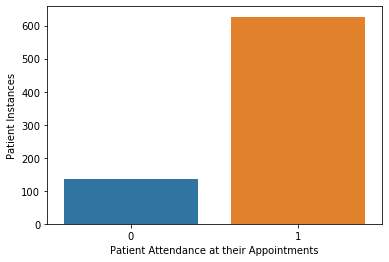

Patients who have 10 or more appointments in this window attend their appointments 82.3% of the time


In [43]:
groups = df[df.PatientId.isin(list(SIndex))].groupby(['Attendance'])
gps = groups.size()
ax = sns.barplot(x=gps.index.tolist(), y=gps.values)
plt.ylabel('Patient Instances')
plt.xlabel('Patient Attendance at their Appointments')
plt.show()
print("Patients who have 10 or more appointments in this window attend their appointments", "{:.1%}".format(df[df.PatientId.isin(list(SIndex))].Attendance.mean()), "of the time")

In [44]:
print("Patients who scheduled their appointments less than two months out attend their appointments", "{:.1%}".format(df.Attendance.mean()), "of the time")

Patients who scheduled their appointments less than two months out attend their appointments 72.0% of the time


Let's add another feature to this data that points out just how many appointments the patient scheduled during this window. 

In [45]:
frequency = pd.value_counts(df.PatientId.values, sort=True, normalize=True)
apptfreqdict={}

for entry in frequency.index:
    apptfreqdict[entry] = frequency[entry]

In [46]:
df['ApptFreq'] = pd.Series(df.PatientId, index=df.index)
df['ApptFreq']= df['ApptFreq'].map(apptfreqdict)
#Apptfreq is the normalized frequency (for model building purposes) of appointments the patient scheduled during this window. 

Just as we've added a feature indicating how frequently someone schedules appointments. We should add a feature that indicates how many appointments this patient has missed. The best indicator for future behavior is past behavior.

In [47]:

x= df[df.Attendance == 0]
FreqOfNoShow={}
for x in df.PatientId.unique():
    FreqOfNoShow[x]=0
    #df['word'].value_counts()
    
absencelist = df[df.Attendance == 0].loc[:,'PatientId']
AbsenceFreq = pd.value_counts(absencelist.values, sort=True, normalize = True)
AbsenceFreq
#AbsenceFreq will be a normalized value that represents how often a patient misses their appointment.
FreqOfNoShow={}
for entry in AbsenceFreq.index:
    FreqOfNoShow[entry] = AbsenceFreq[entry]
    
df['AbsenceFreq'] = pd.Series(df.PatientId, index=df.index)
df['AbsenceFreq']= df['AbsenceFreq'].map(FreqOfNoShow)
df['AbsenceFreq']= df['AbsenceFreq'].fillna(0)

#Now we have variables for how frequently a patient is seen in a 
#window of time and how frequently they've missed appointments


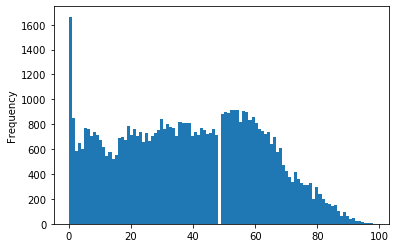

In [48]:
df['Age'].plot.hist(bins =100)

In [ ]:
sns.barplot(x='SMS_Reminders',y='Attendance', data=df[df.WaitFromScheduledDate >2], orient = 'v')
#USing Wait time >2 because there are no text messages sent when the appointment is within 
#three days of the schedule date


Now that we've accounted for potential gaps in the data (missing week of texts, no text sent if the appointment is scheduled for that same day, remove patients who attend super frequently (once every two days)), we see that patients who receive a SMS reminder attend their appointment more frequently

**Neighborhood Insights**

Let's extract all the unique neighborhoods. Classify each neighborhood by its geographic location. Some places may be more accessible to medical care than others.

Went on Google maps and labeled each of the 81 neighborhoods into six regions by their geography and proximity to local clinics. You can see the map of all neighborhoods (blue) and clinics (red) here: <Link>

In [49]:
AllNeighborhoods = pd.read_csv("AllNeighborhoods.csv", usecols=["Neighborhood", "Grouping"],index_col= 'Neighborhood')

Could not place ILHAS OCEÂNICAS DE TRINDADE or PARQUE INDUSTRIAL on the map. Check how many datapoints come from these neighborhoods. Might drop them.

In [51]:
df[((df.Neighborhood == "ILHAS OCEÂNICAS DE TRINDADE") | (df.Neighborhood == "PARQUE INDUSTRIAL"))].shape

(2, 27)

Only two records, so let's drop these. 

In [52]:
df = df[-((df.Neighborhood == "ILHAS OCEÂNICAS DE TRINDADE") | (df.Neighborhood == "PARQUE INDUSTRIAL"))]

Okay so now I want to assign the new variable "Grouping" to the dataframe. 

In [53]:
#First convert the neighborhoods to dictionary
AllNeighborhoods= AllNeighborhoods.to_dict()
AllNeighborhoods= AllNeighborhoods['Grouping']

In [58]:
df['NeighborhoodGrouping'] = df.Neighborhood
df.NeighborhoodGrouping = df.NeighborhoodGrouping.map(AllNeighborhoods)

Now let's create the six dummy variables so that we can use these data in our models. 

In [60]:
dummy = pd.get_dummies(df.NeighborhoodGrouping)
df= pd.concat([df,dummy], axis =1)

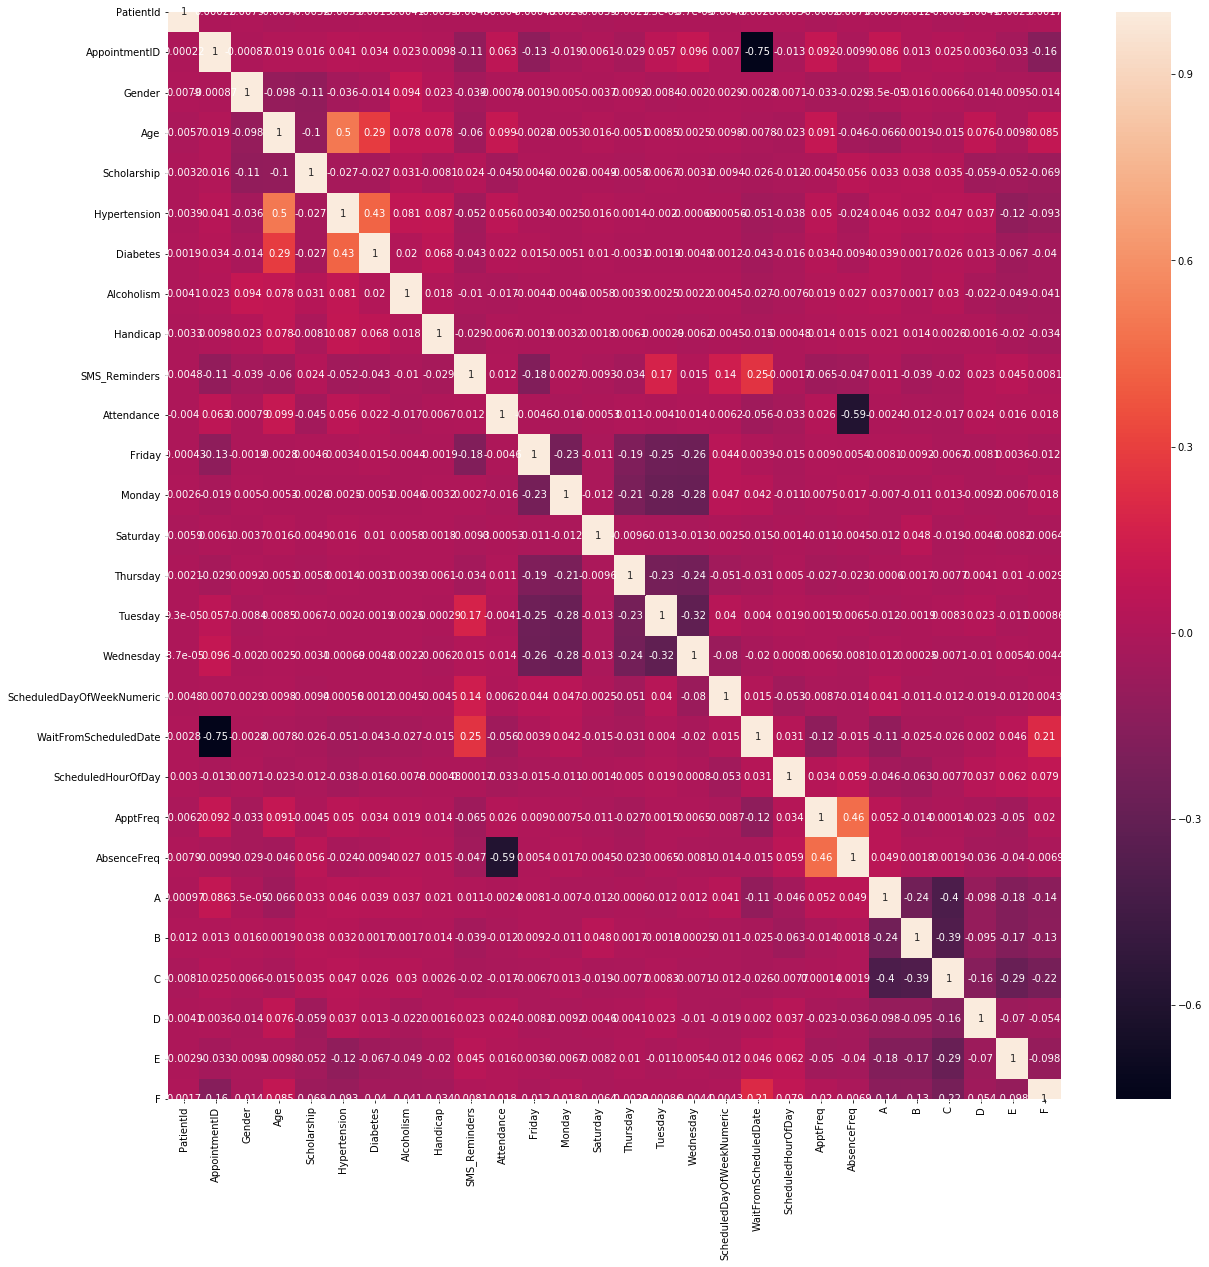

In [61]:
plt.figure(figsize = (20,20))        # Size of the figure
sns.heatmap(df.corr(),annot = True)
plt.show()

Add some commentary on correlations between variables- not just in connection with Attendance. For instance there a positive correlation between neighborhood F and a longer wait time between scheduling and actual appointment day

# Model Building

In [62]:

# Select feature variables to X
X = df.drop(['Attendance', 'PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'AppointmentDayOfWeek','ScheduledDayOfWeek', 'Neighborhood','NeighborhoodGrouping'] ,axis=1)
# Select response variable to y
y = df['Attendance']
X.dtypes

Gender                         int64
Age                            int64
Scholarship                    int64
Hypertension                   int64
Diabetes                       int64
Alcoholism                     int64
Handicap                       int64
SMS_Reminders                  int64
Friday                         uint8
Monday                         uint8
Saturday                       uint8
Thursday                       uint8
Tuesday                        uint8
Wednesday                      uint8
ScheduledDayOfWeekNumeric      int64
WaitFromScheduledDate          int64
ScheduledHourOfDay             int64
ApptFreq                     float64
AbsenceFreq                  float64
A                              uint8
B                              uint8
C                              uint8
D                              uint8
E                              uint8
F                              uint8
dtype: object

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=100)

because the data is heavy with patients who showed up to their appointment (roughly 80/20 breakdown) - we need to adjust our data to better represent these minority populations (the no shows) 

</br> 
</br>
No Smote for now<br>
We will use the Smote technique. See explanation here: https://medium.com/erinludertblog/smote-synthetic-minority-over-sampling-technique-caada3df2c0a

*nvm may not need to use this technique. will revisit this*

In [64]:

sm = SMOTE(kind = "regular")
X_tr,y_tr = sm.fit_sample(X_train,y_train)
#X_tr = X_train
#y_tr = y_train

### Logistic Regression

First try a naive model. Let's see how well a model performs that predicts everyone attends their appointment (which may be the working assumption of the facility now).

In [65]:
AllOnesPredict= np.ones((y_test.shape[0],))
print(confusion_matrix(y_test, AllOnesPredict))
print(classification_report(y_test, AllOnesPredict ))

[[   0 3243]
 [   0 8309]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3243
           1       0.72      1.00      0.84      8309

    accuracy                           0.72     11552
   macro avg       0.36      0.50      0.42     11552
weighted avg       0.52      0.72      0.60     11552



/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Our model must improve upon a 72% baseline accuracy score.

In [66]:
logmodel = LogisticRegression()
logmodel.fit(X_tr, y_tr)
y_predict = logmodel.predict(X_test)
print(classification_report(y_test,y_predict))

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.34      0.59      0.43      3243
           1       0.77      0.54      0.64      8309

    accuracy                           0.56     11552
   macro avg       0.55      0.57      0.53     11552
weighted avg       0.65      0.56      0.58     11552



In [67]:

tn, fp, fn, tp = confusion_matrix( y_test, y_predict).ravel()
print((tn, fp, fn, tp))
print(confusion_matrix( y_test, y_predict))

(1919, 1324, 3805, 4504)
[[1919 1324]
 [3805 4504]]


True negative, False Positive

False Negative, True Positive

This is a pretty cruddy model to represent the data. But it does give us a starting point. We accurately identified 1919 people who missed their appointments. Unfortunately the algorithm classified 3805 people as no-shows, who actually attended their appointment. Meanwhile, the algorithm misses 1324 people who did not attend their appointment, yet the algorithm predicted their attendance. 

This accuracy is even worse that the baseline model that assume everyone will attend their appointment. 

In [ ]:
#What are the variables that are strongly correlating with attendance?
AttendCorr = df.corr()
AttendCorr = AttendCorr.Attendance
AttendCorr.abs().sort_values(ascending=False).head(n=10)


In [69]:

cols =['Gender', 'Age', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_Reminders', 'Friday', 'Monday', 'Saturday', 'Thursday',
       'Tuesday', 'Wednesday', 'WaitFromScheduledDate', 'ScheduledDayOfWeekNumeric',
       'ScheduledHourOfDay', 'ApptFreq', 'AbsenceFreq','A','B','C','D','E','F']
X = df[cols]
y = df['Attendance']
# Build a logreg and compute the feature importances
model = LogisticRegression(solver='lbfgs', max_iter = 3000)
# create the RFE model and select 12 attributes
rfe = RFE(model,10)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))


Selected features: ['Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'SMS_Reminders', 'Friday', 'Monday', 'Thursday', 'Tuesday', 'Wednesday']


Optimal number of features: 1
Selected features: ['Scholarship']


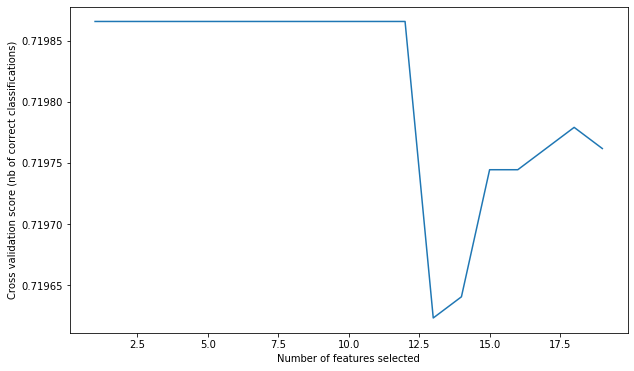

In [70]:

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(solver='lbfgs', max_iter=3000), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

**These are the variables that seem to play a significant impact on modeling Attendance:**

['Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_Reminders', 'Friday', 'Monday', 'Thursday', 'Tuesday', 'Wednesday', 'WaitFromScheduledDate', 'ScheduledHourOfDay']

Yet still we're not cracking over 72% accuracy

Can we delete apptfreq and absencefreq?

In [71]:
def plot_continuous_chart(axe, title, plottype, col, df, log):
    axe.set_title(title)
    if log==True:
        axe.set_yscale('log')
    if (plottype=='d'):   
        sns.distplot(df[col],ax=axe)
    else: 
        sns.boxplot(data =df, x=col,ax=axe,orient='v')
        
def plot_univariate(vtype,col,hue =None,log=False,vertlabel=False, flipvertical=False):
    if vtype == 'continuous':
        fig, ax=plt.subplots(nrows =1,ncols=4,figsize=(15,5))
        plot_continuous_chart(ax[0], "Box Plot", 'b', col, df, log)
        plot_continuous_chart(ax[1], "Distribution Plot", 'd', col, df, log)
        plot_continuous_chart(ax[2], "Box Plot for Show Up", 'b', col, df[df.Attendance == 1], log)
        plot_continuous_chart(ax[3], "Box Plot for No Show", 'b', col, df[df.Attendance == 0], log)
    else:
        fig, ax = plt.subplots()
        hue_col = pd.Series(data = hue)
        width = len(df[col].unique()) + 4 + 2*len(hue_col.unique())
        if flipvertical==True:
            fig.set_size_inches(6 , 8)
            ax = sns.countplot(data = df, y= col, order=df[col].value_counts().index,hue = hue) 
        else:
            fig.set_size_inches(width , 12)
            ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
            for p in  ax.patches:
                if (p.get_height() > 0):
                    ax.annotate('{:1.2f}%'.format((p.get_height()*100)/float(len(df))), (p.get_x()+0.05, p.get_height()+20))  
    if (vertlabel== True): 
        plt.xticks(rotation=90)
    plt.show() 

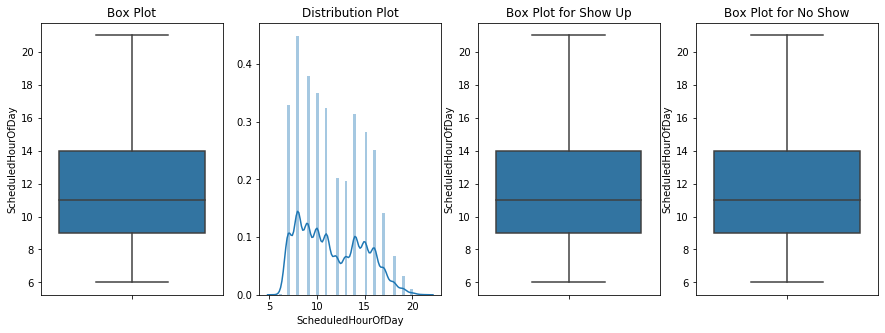

In [72]:
#still planning on how I might use this
plot_univariate(vtype = 'continuous', col='ScheduledHourOfDay', log=False)

### Random Forest Model

In [73]:


model_rf = RandomForestClassifier()
model_rf.fit(X_tr, y_tr)

# Make predictions
prediction_test = model_rf.predict(X_test)
print ('Random Forest Accuracy with Default Hyperparameter on the test set',metrics.accuracy_score(y_test, prediction_test))
print('Random Forest AUC with Default Hyperparameter on the test set',metrics.roc_auc_score(y_test, prediction_test))

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Accuracy with Default Hyperparameter on the test set 0.8975069252077562
Random Forest AUC with Default Hyperparameter on the test set 0.8814686896839603


In [74]:


# GridSearchCV to find optimal n_estimators


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc", return_train_score=True)
rf.fit(X_tr, y_tr)



/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/si

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [75]:
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.158954,0.012192,0.010680,0.000278,2,{'max_depth': 2},0.922403,0.911209,0.945635,0.944339,...,0.937602,0.018746,4,0.940778,0.947972,0.941565,0.927671,0.944817,0.940561,0.006932
1,0.305801,0.019373,0.014238,0.001190,7,{'max_depth': 7},0.964172,0.966132,0.990153,0.992488,...,0.981129,0.013091,3,0.988267,0.987842,0.976773,0.976196,0.979822,0.981780,0.005271
2,0.374752,0.018974,0.016446,0.001272,12,{'max_depth': 12},0.972435,0.976065,0.997864,0.998310,...,0.988591,0.011767,2,0.995810,0.995449,0.991523,0.991657,0.991819,0.993251,0.001947
3,0.408162,0.021946,0.019196,0.002550,17,{'max_depth': 17},0.973666,0.975115,0.998391,0.998498,...,0.988835,0.011803,1,0.999005,0.998784,0.997377,0.997193,0.997518,0.997976,0.000761


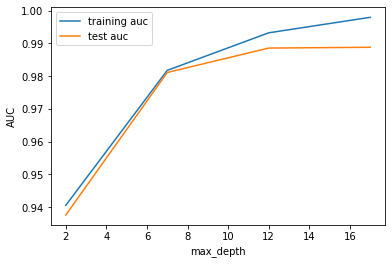

In [76]:


# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training auc")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test auc")
plt.xlabel("max_depth")
plt.ylabel("AUC")
plt.legend()
plt.show()



In [77]:
#GridSearchCV to find optimal n_estimators


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(50, 400, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc", return_train_score=True)
rf.fit(X_tr, y_tr)

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/si

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

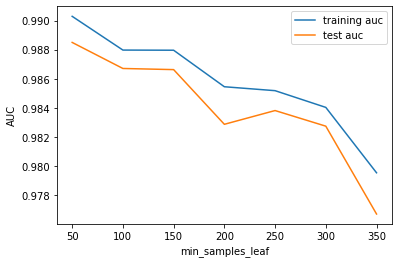

In [78]:
# plotting auc's with min_samples_leaf
scores = rf.cv_results_
pd.DataFrame(scores).head()
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training auc")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test auc")
plt.xlabel("min_samples_leaf")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [79]:
# GridSearchCV to find optimal n_estimators



# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(300, 800, 100)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc", return_train_score=True)
rf.fit(X_tr, y_tr)

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/si

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

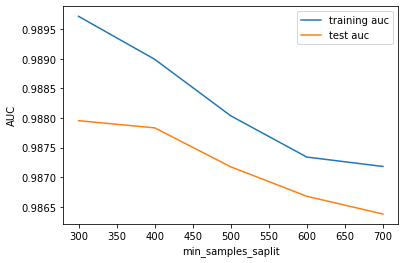

In [80]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training auc")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test auc")
plt.xlabel("min_samples_saplit")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [81]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(300, 700, 200),
    'n_estimators': [100,200], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1, scoring = 'roc_auc')

In [ ]:
grid_search.fit(X_tr, y_tr)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
# printing the optimal accuracy score and hyperparameters
print('We can get an auc of',grid_search.best_score_,'using',grid_search.best_params_)

In [ ]:
# Fitting the RandomForestClassifier using the best parameters obtained by Grid Search CV on the train set
m1= RandomForestClassifier(n_estimators=100,max_depth=8, min_samples_leaf=100,min_samples_split=300, max_features=10, n_jobs=-1)
m1.fit(X_tr,y_tr)
m1.score(X_test,y_test)

In [ ]:
#Predicting probabilities on the balanced training data set, imbalanced training data set and tst set
y_trprob = m1.predict_proba(X_tr)[:,1]
y_trainprob = m1.predict_proba(X_train)[:,1]
y_testprob = m1.predict_proba(X_test)[:,1]

In [ ]:
# Creating a data frame to hold the ground truth 'churn' and the predicted probability for the balanced training dataset
y_tr_pred_final = pd.DataFrame(list(zip(y_tr.tolist(), y_trprob.tolist())),
              columns=['Attendance','Attendance_prob'])


In [ ]:


# Creating a data frame to hold the ground truth 'Attendance' and the predicted probability for the imbalanced training dataset
y_train_pred_final = pd.DataFrame(list(zip(y_train.tolist(), y_trainprob.tolist())),
              columns=['Attendance','Attendance_prob'])



In [ ]:
# Creating a data frame to hold the ground truth 'Attendance' and the predicted probability for the testing dataset
y_test_pred_final = pd.DataFrame(list(zip(y_test.tolist(), y_testprob.tolist())),
              columns=['Attendance','Attendance_prob'])

In [ ]:


# Defining a function to plot the ROC-AUC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None



In [ ]:
fpr, tpr, thresholds = metrics.roc_curve( y_tr_pred_final.Attendance, y_tr_pred_final.Attendance_prob, drop_intermediate = False )

In [ ]:
#Fitting on the balanced dataset
draw_roc(y_tr_pred_final.Attendance, y_tr_pred_final.Attendance_prob)

In [ ]:
#Fitting on the imbalanced dataset
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Attendance, y_train_pred_final.Attendance_prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Attendance, y_train_pred_final.Attendance_prob)

In [ ]:
##Fitting on the test set
fpr, tpr, thresholds = metrics.roc_curve(y_test_pred_final.Attendance, y_test_pred_final.Attendance_prob, drop_intermediate = False )
draw_roc(y_test_pred_final.Attendance, y_test_pred_final.Attendance_prob)

In [ ]:
# Let's create columns with different probability cutoffs on the test set
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_test_pred_final[i]= y_test_pred_final.Attendance_prob.map(lambda x: 1 if x > i else 0)
y_test_pred_final.head()

In [ ]:


# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci', 'preci'])


# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_test_pred_final.Attendance, y_test_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    preci = cm1[1,1]/(cm1[1,1]+cm1[0,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci, preci]
print(cutoff_df)



In [ ]:


# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci', 'preci'])
plt.show()



In [ ]:

metrics.confusion_matrix(y_test_pred_final.Attendance, y_test_pred_final[0.5])

In [ ]:
print(classification_report(y_test_pred_final.Attendance, y_test_pred_final[0.5]))

Great overall scores! 91% accuracy. But what exactly does all this mean? 


So 85% precision rate for patients that don't attend their appointment. This mean that whenver the algorithm predicts no-show, 85% of the time it is correct. However 15% of the time, those are false negatives. 

Recall is a measures the algorithm against all the true labels. So of all the no-show patients, we were able to correctly predict 84% of them. The other 16% the algorithm predicted that they would show up.


Herein lies the grounds for tweaking the algorithm. It's better to err on the side of caution and assume more patients will come to their appointment than to assume they will miss. So we can tolerate reduction to the recall rate. Precision is what we'd really like to improve. When the algorithm predicts negative, we want to hold a high degree of confidence that the patient will not show up before taking alternative course of action.

In [ ]:
metrics.confusion_matrix(y_test_pred_final.Attendance, y_test_pred_final[0.4])

In [ ]:
print(classification_report(y_test_pred_final.Attendance, y_test_pred_final[0.4]))

WE have correctly identified 2301 patients who missed their appointment. Only 156 patients were predicted to miss but actually showed up. 

This however misses 834 patients who actually were no-shows, which the algorithm classified as attending. This is the algorithmic cost of greater certainty that that the algorithm will correct an actual no-show. 

Is there anything interesting we can dig up on the population that gets cut here?

**What do we observe about the 156 patients who were predicted to miss but actually showed up?**

**What do we observe about the 834 patients who were predicted to attend, but missed their appointment?**

In [ ]:


feature_importances = pd.DataFrame(m1.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(10)



Okay so... As we expected, prior absences are the best predictor for future absences. Variables drop off in importance pretty rapidly afterward. 

What's more interesting are the nieghborhoods that are in the top ten on the list (Jardim Camburi & Maria Ortiz). What's happening in these areas that is potentially impacting the rate at which people attend their appointments?


# PCA Analysis

"Principal Component Analysis (PCA) is an unsupervised, non-parametric statistical technique primarily used for dimensionality reduction in machine learning.

High dimensionality means that the dataset has a large number of features. The primary problem associated with high-dimensionality in the machine learning field is model overfitting, which reduces the ability to generalize beyond the examples in the training set. Richard Bellman described this phenomenon in 1961 as the Curse of Dimensionality where “Many algorithms that work fine in low dimensions become intractable when the input is high-dimensional. "

https://medium.com/apprentice-journal/pca-application-in-machine-learning-4827c07a61db

This ought to stress the importance of nailing down what features are critical to the development of an algorithm than going with the "Throw all the possible data at the model!"

# Feature Scaling



In [ ]:
X_tr=pd.DataFrame(data=X_tr,columns=X_train.columns)

In [ ]:
scaler = StandardScaler()

X_tr[X_train.columns] = scaler.fit_transform(X_tr[X_train.columns])

X_tr.describe()

In [ ]:
X_te = scaler.transform(X_test)

In [ ]:
X_te = pd.DataFrame(data = X_test,columns= X_train.columns)

# PCA Analysis


In [ ]:

pca = PCA(svd_solver='randomized', random_state=42)

In [ ]:
#PCA on the train data
pca.fit(X_tr)

In [ ]:
pca.components_

In [ ]:
colnames = list(X_tr.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head(10)

In [ ]:
%matplotlib inline
fig = plt.figure(figsize = (12,12))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

Interesting... we can see which variables are clustered near each other and might be experiencing some degreee of a  collinearity issue.

Similiar variables:


[Absencefreq, ApptFreq]
[Age, Diabetes, Hypertension]
[Tuesday, WaitFromScheduledDate, SMSReminders]
[Thursday,Saturday, Monday, Geder, Handicap, Alcoholism, WEdnesday, ScheduledHourofDay, Scholarship, Friday]

In [ ]:
pca.explained_variance_ratio_

In [ ]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Select somewhere between 15-17 features to explain the variance... After that, the the graph of explained variance approaches an asymptote

In [ ]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets

pca_final = IncrementalPCA(n_components=16)

In [ ]:
df_train_pca = pca_final.fit_transform(X_tr)
df_train_pca.shape

In [ ]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

In [ ]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)
plt.show()

In [ ]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

Low correlation scores = Confirmed that we've removed multicolinearity issues

In [ ]:
#Applying selected components to the test data - 40 components
df_test_pca = pca_final.transform(X_te)
df_test_pca.shape

# Logistic Regression Post PCA

In [ ]:
#Training the model on the train data


learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_tr)

In [ ]:
#Making prediction on the train data
pred_probs_train = model_pca.predict_proba(df_train_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_tr, pred_probs_train))

In [ ]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

Predictions on the training data

In [ ]:
predictions_train = model_pca.predict(df_train_pca)

In [ ]:
print(confusion_matrix(y_tr,predictions_train))

In [ ]:
print(classification_report(y_tr,predictions_train))

In [ ]:
predictions_test = model_pca.predict(df_test_pca)

In [ ]:
print(confusion_matrix(y_test,predictions_test))

In [ ]:
print(classification_report(y_test,predictions_test))

What does this tell us about our data / models that we get such a poor accuracy score after PCA to account for correlations among variables?

In [ ]:
# Creating a data frame to hold the ground truth 'churn' and the predicted probability for the imbalanced training dataset
pca_y_train_pred_final = pd.DataFrame(list(zip(y_tr.tolist(), pred_probs_train.tolist())),
              columns=['Attendance','Attendance_prob'])

In [ ]:
# Creating a data frame to hold the ground truth 'churn' and the predicted probability for the testing dataset
pca_y_test_pred_final = pd.DataFrame(list(zip(y_test.tolist(), pred_probs_test.tolist())),
              columns=['Attendance','Attendance_prob'])

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(pca_y_train_pred_final.Attendance, pca_y_train_pred_final.Attendance_prob, drop_intermediate = False )

In [ ]:
draw_roc(pca_y_train_pred_final.Attendance, pca_y_train_pred_final.Attendance_prob)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve( pca_y_test_pred_final.Attendance, pca_y_test_pred_final.Attendance_prob, drop_intermediate = False )

In [ ]:
draw_roc(pca_y_test_pred_final.Attendance, pca_y_test_pred_final.Attendance_prob)

From this figure we can make a policy recommendation - as much as possible - try to schedule appointments less than 10 days out. Further out, we run a higher risk of no-shows.

In [ ]:


# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    
    return mae, rmse



In [ ]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.ix[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.ix['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [ ]:
df.dtypes

In [ ]:
# Putting feature variable to X
X = df.drop(['Attendance', 'PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'AppointmentDayOfWeek','ScheduledDayOfWeek', 'Neighborhood','NeighborhoodGrouping'] ,axis=1)
# Putting response variable to y
y = df['Attendance']
X.dtypes
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=100)

In [ ]:
# Load data

X_trainGB = X_train.to_numpy()

In [ ]:
X_testGB = X_test.to_numpy()


In [ ]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_trainGB, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

In [ ]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_testGB)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(12,8))
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(np.arange(0, 25, step=1))


#plt.yticks(pos, df.get_feature_names([sorted_idx]))
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

plt.show()


In [ ]:
selection=[]
for i in y_pred:
    if i >= 0.4:
        selection.append(1)
    else:
        selection.append(0)

selectionfortesting = np.asarray(selection)

In [ ]:
print(confusion_matrix(y_test, selectionfortesting))
print(classification_report(y_test, selectionfortesting ))

91% accuracy
96% precision = Only 4% of the time when the algorithm produces a no-show, did the patient actually show up.

98 cases where patient showed up but the algorithm predicted no-show. Meanwhile 2255 patients were correctly identified as no-shows. 

### Rough ideas below

Look into MLPRegressor as a neurl network option when finished

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor



WE trashed a bunch of data because of unclear tags or questionable collection practices. standards around data collection. Standards around algorithm inputs/ outputs. What is important to collect in a registry?

This might be too painstaking to pull a list of municipalities for ech state and match it with the dataset

Okay so I mapped all the neighborhoods on Google Maps to find trends in our data: 

https://drive.google.com/open?id=1jTljTssx4dSY84k-CljRAg3YB0LOUVLO&usp=sharing

I plotted each neighborhood on the map. But now  I want to consider where all the clincics/hospitals are in Vitoria. This should help me make bins for all the locations. What groups are likely going to the same facility?

The red denotes a hospital/ clinic / 


Okay so I need to figure out the specific lines to differeniate regions. Region 1 makes sense - no clinics/ hospitals in the the near vicinity. These people will need to travel the furthest. 

Region 2 has one local facility but is the next most rural population in the group. Neighborhoods are slightly more dense thatn region 1. 

Okay what's goiong on in jardim de penha. Are there are lot of visits from this neighborhood? Same with Pontal de Camburi. IF there are a lot of visits between those two, then we should create its own bucket. 

Okay, so two neighborhoods out of 80 possible. Let's make a quick (clearly incorrect) assumption that these neighborhoods are evently distributed and make clinical appointments at similar frequencies. So these neighborhoods should account for 2.5% of the total data. If these neighborhoods actually account for more, then we will create separate buckets to see what's going on. 



Can I predict who's on scholarship?

OH scholarship is at 9% in the data. Statewide it's at 26%. This is a wealthier population. Wealthier people do not come as often to their public service appointmentS? sio when trained on another city, it's very feasible to think that this will undertrain on poorer populations and return more no-shows than actually exist. 

In [ ]:


JardimCamburi = df[df.Neighborhood == "JARDIM CAMBURI"]
MariaOrtiz = df[df.Neighborhood == "MARIA ORTIZ"]
JardimDaPenha = df[df.Neighborhood == "JARDIM DA PENHA"]

In [ ]:
print("Jardim Camburi: Attendance =",JardimCamburi.Attendance.mean(), "Count = ",JardimCamburi.shape[0])
print("Maria Ortiz: Attendance = ",MariaOrtiz.Attendance.mean(), "Count =", MariaOrtiz.shape[0])
print("Jardim Da Penha: Attendance = ",JardimDaPenha.Attendance.mean(),"Count = ", JardimDaPenha.shape[0])


This bit is out of place. Find a new home

Potential relationships to investigate (pulled from the correlation table.<br />
AppointmentID : SMS<br />
Age : Gender<br />
Age : Scholarship<br />
Age : Handicap<br />
Hypertension : Age<br />
Hypertension : Diabetes<br />
Diabetes : Age<br />
Alcoholism : Gender<br />
ApptFreq : Alcoholism<br />
Scholarship : AbsenceFreq<br />
Hypertension : Handicap

**Discussion Question:**

- What are some notable biases in the algorithm? What might these biases mean for practice if this sort of algorithm were to roll out?
- How well does this data represent the Vitoria population?
- Could we build an algorithm that could predict someone's income status or condition information?
- What are the important variables that an algorithm should have access to? Where should access be limited?
- What are some common evaluation metrics to understand how well a classifier performs?
- How could I get started on some inhouse ML projects?
- What are the critical targets to hit? 
- How well do we need to hit them? 
- What data should we grant access to the algorithm? 
- What should the algorithm return?
- What are some best practices for disclosing how models were trained and tested?
- What are acceptable assumptions to improve model accuracy? What window of patients do we need to nail down? For instance I made an assumption that this model would best work for patients who've scheduled their appointments by 60 days out. 



In [ ]:
df.columns